El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3533131/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "Balancer"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "3d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = None


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 111987 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111987 entries, 0 to 111986
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       111987 non-null  object        
 1   name           111987 non-null  object        
 2   id             111987 non-null  object        
 3   proposal       111987 non-null  category      
 4   deployment     111987 non-null  object        
 5   platform_vote  111987 non-null  object        
 6   voter          111987 non-null  category      
 7   date           111987 non-null  datetime64[ns]
 8   choice         111987 non-null  object        
 9   weight         111987 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 509 entries, 0 to 508
Data columns (total 13 columns):
 #   Column            

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x89be0c2dfe1f5b7bd05ffb2097f85837a5eafe18,e2687fb1-2f19-5b7c-b201-49f1f9d0545c,2023-03-20 17:52:19,1
1,0x631f82fb2a62496d28780a821f47786b05e2278a,e2687fb1-2f19-5b7c-b201-49f1f9d0545c,2023-03-20 17:06:41,1
2,0x5244736b3a8f898149ae33f013126a20ce7abc62,e2687fb1-2f19-5b7c-b201-49f1f9d0545c,2023-03-20 16:13:06,1
3,0x896002e29fe4cda28a3ae139b0bf7bac26b33a8c,e2687fb1-2f19-5b7c-b201-49f1f9d0545c,2023-03-20 16:12:11,1
4,0xf9126867253503cc1c3bad58e180c260cbbbd329,e2687fb1-2f19-5b7c-b201-49f1f9d0545c,2023-03-20 14:43:28,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          509
mean     3 days 09:39:27.039292730
std      0 days 17:46:18.009736232
min                1 days 00:00:00
25%                3 days 00:00:00
50%                4 days 00:00:00
75%                4 days 00:00:00
max                5 days 00:00:00
dtype: object

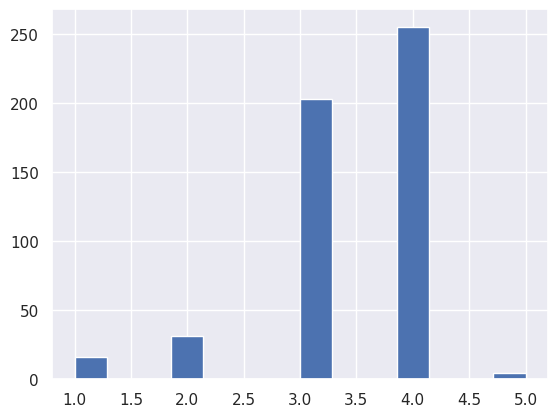

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [7]:
delta.value_counts()

4 days 00:00:00    254
3 days 00:00:00    198
2 days 00:00:00     23
1 days 00:00:00     16
5 days 00:00:00      4
2 days 05:00:00      3
3 days 07:00:00      2
3 days 01:00:00      2
2 days 18:00:00      1
4 days 00:20:06      1
2 days 21:20:00      1
2 days 04:00:00      1
2 days 23:45:00      1
3 days 01:15:17      1
2 days 16:00:00      1
dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

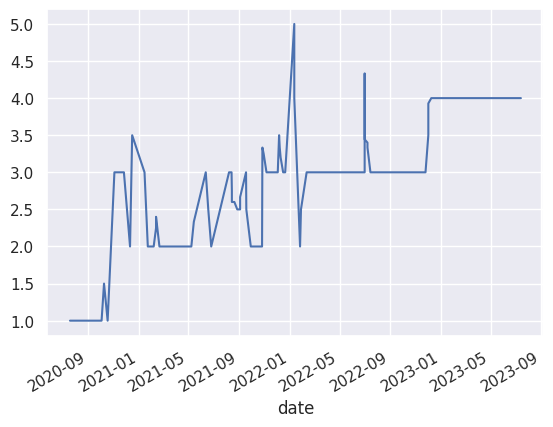

In [8]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Thursday     378
Friday        75
Saturday      22
Monday        14
Tuesday       11
Wednesday      7
Sunday         2
Name: start, dtype: int64

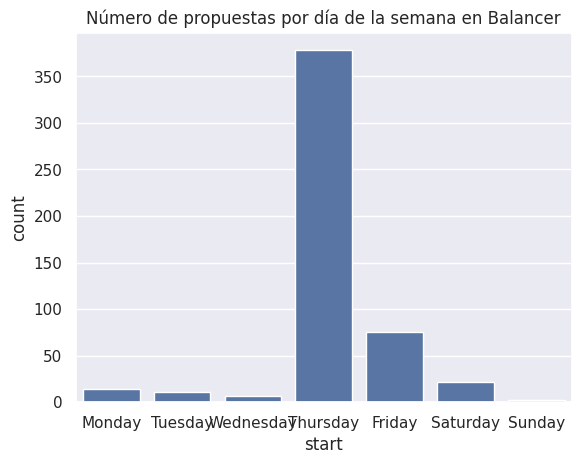

In [9]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

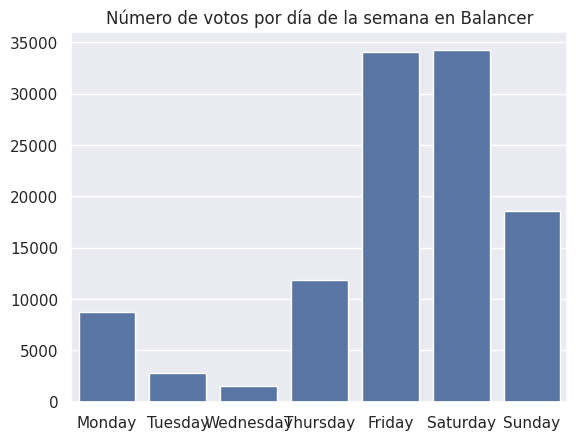

In [10]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

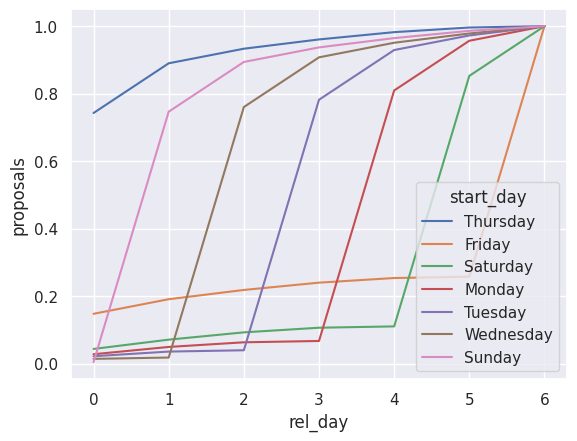

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

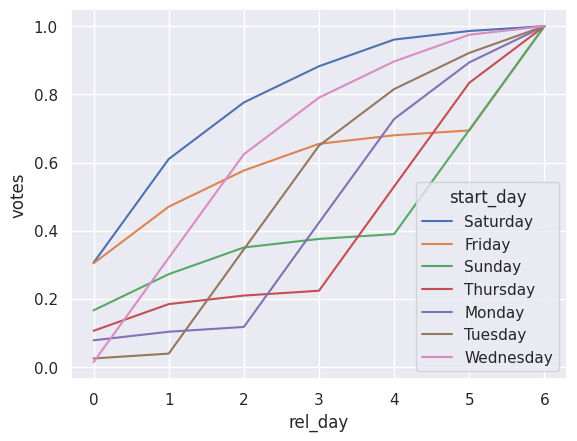

In [12]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

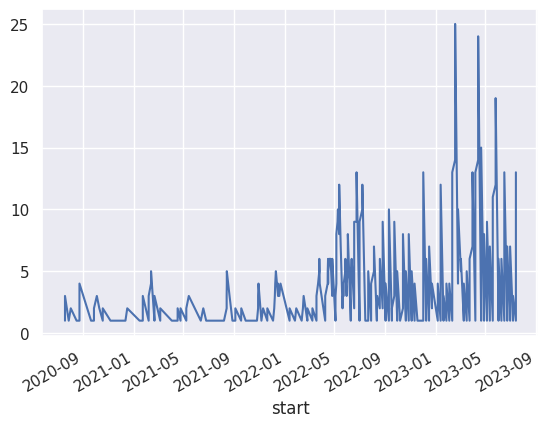

In [13]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [14]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                            W-SUN        W-MON        W-TUE  \
votes in open proposals (train) count   156.000000   156.000000   155.000000   
                                mean    466.634615   360.371795    20.032258   
                                std     626.018974   686.071606    95.558809   
                                min       0.000000     0.000000     0.000000   
                                50%     251.500000     0.000000     0.000000   
                                max    3433.000000  3324.000000   672.000000   
users in open proposals (train) count   156.000000   156.000000   155.000000   
                                mean    169.750000   101.519231    19.000000   
                                std     256.686444   189.635082    94.917599   
                                min       0.000000     0.000000     0.000000   
                                50%      98.000000     0.000000     0.000000   
                                max    1764.000000  1099.000000   672.000000   
open proposals                  count   156.000000   156.000000   155.000000   
                                mean      2.974359     1.955128     0.154839   
                                std       3.486284     3.512821     0.536244   
                                min       0.000000     0.000000     0.000000   
                                50%       2.000000     0.000000     0.000000   
                                max      15.000000    15.000000     4.000000   
votes in test                   count   156.000000   156.000000   155.000000   
                                mean    159.044872    61.320513    19.638710   
                                std     289.943228   182.406246   142.756440   
                                min       0.000000     0.000000     0.000000   
                                50%      41.000000     0.000000     0.000000   
                                max    1976.000000  1837.000000  1628.000000   
users in test                   count   156.000000   156.000000   155.000000   
                                mean     68.948718    32.448718    18.135484   
                                std     189.191857   165.081770   141.878862   
                                min       0.000000     0.000000     0.000000   
                                50%      24.500000     0.000000     0.000000   
                                max    1976.000000  1837.000000  1628.000000   
vpp test                        count   111.000000    62.000000    16.000000   
                                mean     82.918287    74.023916   173.114583   
                                std     214.972298   256.438012   421.737937   
                                min       0.000000     0.000000     0.000000   
                                50%      28.000000    17.875000    38.166667   
                                max    1976.000000  1837.000000  1628.000000   
vpu test                        count   109.000000    61.000000    14.000000   
                                mean      2.831421     3.241216     1.354286   
                                std       2.027798     2.282604     0.631358   
                                min       1.000000     1.000000     1.000000   
                                50%       2.180000     2.425532     1.000000   
                                max       9.675676     9.169231     3.180328   

f                                            W-WED        W-THU        W-SAT  
votes in open proposals (train) count   155.000000   155.000000   155.000000  
                                mean     13.019355    17.419355   274.219355  
                                std      65.393164    54.772240   419.851570  
                                min       0.000000     0.000000     0.000000  
                                50%       0.000000     0.000000    79.000000  
                                max     741.000000   283.000000  2124.000000  
users 

In [15]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3533131/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),72795.000000,56218.000000,3105.000000,2018.000000,2700.000000,42504.000000
users in open proposals (train),26481.000000,15837.000000,2945.000000,1719.000000,2074.000000,12514.000000
open proposals,464.000000,305.000000,24.000000,26.000000,30.000000,447.000000
votes in test,24811.000000,9566.000000,3044.000000,4375.000000,7527.000000,44723.000000
users in test,10756.000000,5062.000000,2811.000000,4048.000000,4953.000000,16982.000000
vpp test,9203.929823,4589.482781,2769.833333,3689.916667,4745.500000,14878.013104
vpu test,308.624907,197.714201,18.960009,22.335342,27.244494,323.059619


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [16]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [17]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [18]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [19]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2020-10-18 22:36:16)  =====
Currently open proposals: 2
Train votes in open proposals:  37
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-01-24 22:59:36)  =====
Currently open proposals: 3
Train votes in open proposals: 762
Test votes in open proposals:    0

===== Training on fold 2 (t: 2021-05-09 22:56:39)  =====
Currently open proposals: 2
Train votes in open proposals: 2141
Test votes in open proposals:    0



===== Training on fold 3 (t: 2021-08-20 12:18:02)  =====
Currently open proposals: 1
Train votes in open proposals:   1
Test votes in open proposals:  172



===== Training on fold 4 (t: 2021-11-22 16:18:42)  =====
Currently open proposals: 2
Train votes in open proposals: 1417
Test votes in open proposals:    0



===== Training on fold 5 (t: 2022-02-27 14:46:38)  =====
Currently open proposals: 2
Train votes in open proposals: 1397
Test votes in open proposals:    0



===== Training on fold 6 (t: 2022-06-14 13:31:02)  =====
Currently open proposals: 1
Train votes in open proposals:  61
Test votes in open proposals:    0



===== Training on fold 7 (t: 2022-09-19 21:07:48)  =====
Currently open proposals: 2
Train votes in open proposals: 262
Test votes in open proposals:    0



===== Training on fold 8 (t: 2022-12-26 16:41:46)  =====
Currently open proposals: 3
Train votes in open proposals: 777
Test votes in open proposals:    0



===== Training on fold 9 (t: 2023-04-09 06:52:42)  =====
Currently open proposals: 13
Train votes in open proposals: 2580
Test votes in open proposals:  543


In [20]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.096000,0.190356,0.153932,0.156850,0.078769,0.193778,0.179919,0.188448,0.062359,0.194241,0.191332,0.200000,0.100923,0.079538
std,0.241624,0.401949,0.342201,0.345956,0.216250,0.408782,0.382244,0.398215,0.175031,0.409721,0.403880,0.421637,0.256688,0.218657
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.760000,1.000000,1.000000,1.000000,0.687692,1.000000,1.000000,1.000000,0.556923,1.000000,1.000000,1.000000,0.809231,0.695385


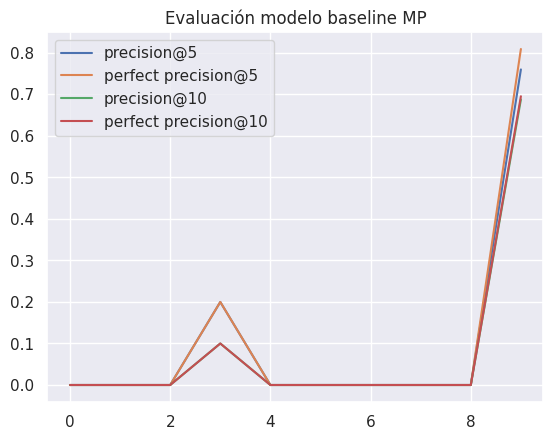

In [21]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.100923,0.200000,0.164388,0.164388,0.079538,0.200000,0.189191,0.189191,0.062359,0.200000,0.200000,0.200000
std,0.256688,0.421637,0.356581,0.356581,0.218657,0.421637,0.399663,0.399663,0.175031,0.421637,0.421637,0.421637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.809231,1.000000,1.000000,1.000000,0.695385,1.000000,1.000000,1.000000,0.556923,1.000000,1.000000,1.000000


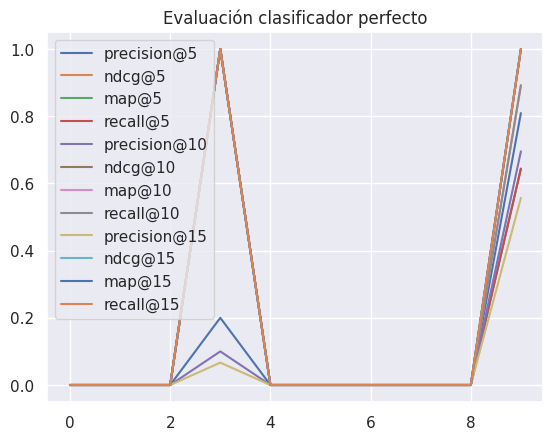

In [22]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [23]:
from tqdm.autonotebook import tqdm

In [24]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/363 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2
Warning, empty test fold 3


Warning, empty test fold 5
Warning, empty test fold 6
Warning, empty test fold 7
Warning, empty test fold 8
Warning, empty test fold 9
Warning, empty test fold 10


Warning, empty test fold 12
Warning, empty test fold 13
Warning, empty test fold 14
Warning, empty test fold 15
Warning, empty test fold 16
Warning, empty test fold 17


Warning, empty test fold 18
Warning, empty test fold 19
Warning, empty test fold 20
Warning, empty test fold 21
Warning, empty test fold 22
Warning, empty test fold 23


Warning, empty test fold 24
Warning, empty test fold 26


Warning, empty test fold 28
Warning, empty test fold 29
Warning, empty test fold 30
Warning, empty test fold 31
Warning, empty test fold 32
Warning, empty test fold 33


Warning, empty test fold 34
Warning, empty test fold 35


Warning, empty test fold 37
Warning, empty test fold 38
Warning, empty test fold 39
Warning, empty test fold 40
Warning, empty test fold 41
Warning, empty test fold 42


Warning, empty test fold 44
Warning, empty test fold 45
Warning, empty test fold 46
Warning, empty test fold 47


Warning, empty test fold 49


Warning, empty test fold 52
Warning, empty test fold 53
Warning, empty test fold 54
Warning, empty test fold 55
Warning, empty test fold 56
Warning, empty test fold 57


Warning, empty test fold 58
Warning, empty test fold 59


Warning, empty test fold 61
Warning, empty test fold 63


Warning, empty test fold 64
Warning, empty test fold 65
Warning, empty test fold 66


Warning, empty test fold 68
Warning, empty test fold 70


Warning, empty test fold 71
Warning, empty test fold 72
Warning, empty test fold 73
Warning, empty test fold 74
Warning, empty test fold 75


Warning, empty test fold 77
Warning, empty test fold 78


Warning, empty test fold 79
Warning, empty test fold 80
Warning, empty test fold 81


Warning, empty test fold 82
Warning, empty test fold 83
Warning, empty test fold 84


Warning, empty test fold 85
Warning, empty test fold 86
Warning, empty test fold 87


Warning, empty test fold 89


Warning, empty test fold 91
Warning, empty test fold 92


Warning, empty test fold 93
Warning, empty test fold 94


Warning, empty test fold 95
Warning, empty test fold 96


Warning, empty test fold 98


Warning, empty test fold 100
Warning, empty test fold 101


Warning, empty test fold 102
Warning, empty test fold 103


Warning, empty test fold 104
Warning, empty test fold 105


Warning, empty test fold 106
Warning, empty test fold 107


Warning, empty test fold 108


Warning, empty test fold 110


Warning, empty test fold 112
Warning, empty test fold 113


Warning, empty test fold 114
Warning, empty test fold 115


Warning, empty test fold 116
Warning, empty test fold 117


Warning, empty test fold 118
Warning, empty test fold 119


Warning, empty test fold 120
Warning, empty test fold 121


Warning, empty test fold 122
Warning, empty test fold 123


Warning, empty test fold 124
Warning, empty test fold 125


Warning, empty test fold 126
Warning, empty test fold 127


Warning, empty test fold 129


Warning, empty test fold 131


Warning, empty test fold 133
Warning, empty test fold 134


Warning, empty test fold 135
Warning, empty test fold 136


Warning, empty test fold 138


Warning, empty test fold 139
Warning, empty test fold 140


Warning, empty test fold 141


Warning, empty test fold 143
Warning, empty test fold 144


Warning, empty test fold 146
Warning, empty test fold 147


Warning, empty test fold 148
Warning, empty test fold 149


Warning, empty test fold 150


Warning, empty test fold 152
Warning, empty test fold 153


Warning, empty test fold 157


Warning, empty test fold 160
Warning, empty test fold 161


Warning, empty test fold 162


Warning, empty test fold 164
Warning, empty test fold 165


Warning, empty test fold 166


Warning, empty test fold 174


Warning, empty test fold 175


Warning, empty test fold 176


Warning, empty test fold 177


Warning, empty test fold 178


Warning, empty test fold 179
Warning, empty test fold 180


Warning, empty test fold 182


Warning, empty test fold 183


Warning, empty test fold 184


Warning, empty test fold 187


Warning, empty test fold 188


Warning, empty test fold 189


Warning, empty test fold 193


Warning, empty test fold 194


Warning, empty test fold 196


Warning, empty test fold 197


Warning, empty test fold 198


Warning, empty test fold 200


Warning, empty test fold 201


Warning, empty test fold 203


Warning, empty test fold 206


Warning, empty test fold 207


Warning, empty test fold 208


Warning, empty test fold 210


Warning, empty test fold 216


Warning, empty test fold 217


Warning, empty test fold 225


Warning, empty test fold 229


Warning, empty test fold 232


Warning, empty test fold 234


Warning, empty test fold 236


Warning, empty test fold 240


Warning, empty test fold 241


Warning, empty test fold 243


Warning, empty test fold 245


Warning, empty test fold 247


Warning, empty test fold 248


Warning, empty test fold 250


Warning, empty test fold 252


Warning, empty test fold 254


Warning, empty test fold 255


Warning, empty test fold 257


Warning, empty test fold 259


Warning, empty test fold 260


Warning, empty test fold 262


Warning, empty test fold 264


Warning, empty test fold 266


Warning, empty test fold 268


Warning, empty test fold 269


Warning, empty test fold 271


Warning, empty test fold 273


Warning, empty test fold 275


Warning, empty test fold 276


Warning, empty test fold 278


Warning, empty test fold 280


Warning, empty test fold 282


Warning, empty test fold 283


Warning, empty test fold 285


Warning, empty test fold 287


Warning, empty test fold 290


Warning, empty test fold 292


Warning, empty test fold 294


Warning, empty test fold 297


Warning, empty test fold 298


Warning, empty test fold 299


Warning, empty test fold 301


Warning, empty test fold 304


Warning, empty test fold 306


Warning, empty test fold 308


Warning, empty test fold 311


Warning, empty test fold 313


Warning, empty test fold 315


Warning, empty test fold 318


Warning, empty test fold 320


Warning, empty test fold 322


Warning, empty test fold 325


Warning, empty test fold 327


Warning, empty test fold 329


Warning, empty test fold 332


Warning, empty test fold 334


Warning, empty test fold 336


Warning, empty test fold 339


Warning, empty test fold 341


Warning, empty test fold 343


Warning, empty test fold 346


Warning, empty test fold 348


Warning, empty test fold 350


Warning, empty test fold 353


Warning, empty test fold 355


Warning, empty test fold 357


Warning, empty test fold 360


Warning, empty test fold 362


In [25]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2020-07-18 16:12:04 2023-07-17 17:57:23


t0: 2020-07-21 00:00:00
t1: 2020-07-24 00:00:00
t-2: 2023-07-09 00:00:00
t-1: 2023-07-12 00:00:00


In [26]:
{ k:len(v) for k,v in metrics.items() }

{'t': 363,
 'precision@5': 363,
 'ndcg@5': 363,
 'map@5': 363,
 'recall@5': 363,
 'precision@10': 363,
 'ndcg@10': 363,
 'map@10': 363,
 'recall@10': 363,
 'precision@15': 363,
 'ndcg@15': 363,
 'map@15': 363,
 'recall@15': 363}

In [27]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2020-07-18 16:08:19')

Timestamp('2020-07-18 16:12:04')

,userID,itemID,timestamp,rating
25700,0x28143659f4500411d9e49513b88e66cdf81f9002,e41b9c54-4da0-554e-ad10-8a2397d4c2b2,2020-07-18 16:12:04,1
70894,0x4aa2c2c321d86e6ce9c5b1fad7c2e084d867dea3,f3a84703-d173-500e-83e5-d5314a5946ef,2020-07-18 16:12:18,1
70893,0x911f80d16ec1b70db332227b03beb871ac58ead7,f3a84703-d173-500e-83e5-d5314a5946ef,2020-07-18 16:12:22,1
70892,0xd98e44d09660a89022515d6d41662d05a14253e7,f3a84703-d173-500e-83e5-d5314a5946ef,2020-07-18 16:12:39,1
25699,0xd98e44d09660a89022515d6d41662d05a14253e7,e41b9c54-4da0-554e-ad10-8a2397d4c2b2,2020-07-18 16:13:31,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
181,snapshot,Balancer,balancer.eth,f3a84703-d173-500e-83e5-d5314a5946ef,6b341057-a48e-59a4-96d9-eb42e0e4f602,QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ,0x8bbe4ac64246d600bc2889ef5d83809d138f03df,2020-07-18 16:08:19,balFactor: incentivizing BAL liquidity on Bala...,Read the formatted version of this proposal at...,2020-07-18 16:00:00,2020-07-19 16:00:00,97
62,snapshot,Balancer,balancer.eth,e41b9c54-4da0-554e-ad10-8a2397d4c2b2,6b341057-a48e-59a4-96d9-eb42e0e4f602,QmXYVj4GBu16GfuTLouxQSvbB8w3G2EAvYq9TAxX38ruKb,0x8bbe4ac64246d600bc2889ef5d83809d138f03df,2020-07-18 16:08:43,Modifying feeFactor: toward reducing the minin...,Read the formatted version of this proposal at...,2020-07-18 16:00:00,2020-07-19 16:00:00,72
355,snapshot,Balancer,balancer.eth,8d31d5fb-a986-53c8-a3b1-033ae29aca92,6b341057-a48e-59a4-96d9-eb42e0e4f602,QmboDWvsXYXPZb44arPVoMa3LHuv74YsGZ3cSoG6uj4oZe,0x8bbe4ac64246d600bc2889ef5d83809d138f03df,2020-07-18 16:14:39,Modifying wrapFactor: applying a 0.7 factor to...,Read the formatted version of this proposal at...,2020-07-18 16:00:00,2020-07-19 16:00:00,83
445,snapshot,Balancer,balancer.eth,9c2c2863-fab2-5fcd-b0fb-a88f92283c3f,6b341057-a48e-59a4-96d9-eb42e0e4f602,QmeWmvdFCTq5tnFHqgFmAVJDCccTYjg1zWb9cfUByg7zbz,0x8bbe4ac64246d600bc2889ef5d83809d138f03df,2020-07-27 08:07:44,First batch of grants from Balancer Ecosystem ...,[This proposal is also on Balancer's forum.](h...,2020-07-27 16:00:00,2020-07-28 16:00:00,31
35,snapshot,Balancer,balancer.eth,5a46decb-3ee2-5e1c-a832-e456a7634a85,6b341057-a48e-59a4-96d9-eb42e0e4f602,QmUadcUgd3jAhJbofgrnKNMfeuGFvMmybhCkttW4gGfYYJ,0x107174d70b33523e83711ea4c3f4229cdb8a7cb1,2020-07-31 20:20:25,Modifying wrapFactor: applying a 0.2 factor to...,[This proposal has been posted by user 5325235...,2020-08-01 16:00:00,2020-08-02 16:00:00,107


In [28]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,0.175632,0.348540,0.318734,0.341855,0.108543,0.352700,0.340665,0.370467,0.075482,0.353188,0.344325,0.374656,0.181468,0.109159,0.371459
std,0.269565,0.454512,0.428526,0.452681,0.185236,0.458670,0.446227,0.479864,0.134252,0.459238,0.449956,0.484702,0.280626,0.187170,0.480907
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.290472,0.913904,0.844507,1.000000,0.145236,0.925342,0.888627,1.000000,0.096824,0.930056,0.898945,1.000000,0.290472,0.145236,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.815858,1.000000,1.000000,1.000000,0.696014,1.000000,1.000000,1.000000,1.000000,0.845652,1.000000


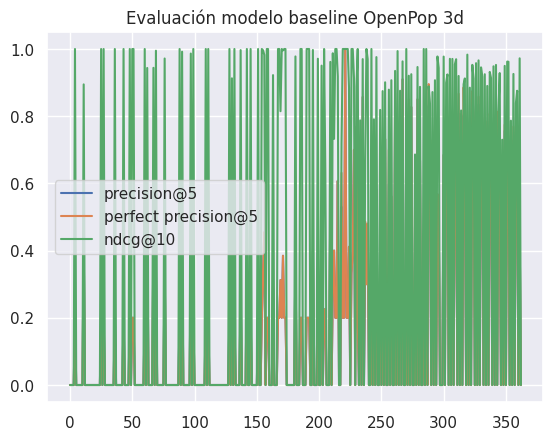

In [29]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [30]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.310630,0.425317,0.348444,0.407819,0.204650,0.439931,0.412511,0.494119,0.140734,0.440933,0.417430,0.500000,0.328404,0.205940,0.495947
std,0.338120,0.452533,0.383917,0.437647,0.226323,0.466238,0.441619,0.521142,0.155614,0.467076,0.444924,0.527046,0.357376,0.227614,0.522914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.233333,0.378661,0.263333,0.331704,0.116667,0.393330,0.329257,0.470596,0.077778,0.398341,0.353851,0.500000,0.233333,0.116667,0.479735
75%,0.636972,0.846352,0.660052,0.782873,0.448534,0.866503,0.819470,1.000000,0.310768,0.866503,0.819470,1.000000,0.687390,0.451760,1.000000
max,0.727586,0.972222,0.962963,1.000000,0.479310,0.972222,0.962963,1.000000,0.319540,0.972222,0.962963,1.000000,0.768966,0.479310,1.000000


,t,model,variable,value
0,2020-07-19 15:53:31,openpop,precision@5,0.000000
1,2020-07-19 15:53:31,openpop,precision@5,0.000000
2,2020-07-19 15:53:31,openpop,precision@5,0.000000
3,2020-07-28 15:41:46,openpop,precision@5,0.000000
4,2020-08-01 23:57:58,openpop,precision@5,0.200000
...,...,...,...,...
1447,2023-06-29 21:41:02,perfect,recall@5,0.866158
1448,2023-07-02 20:32:21,perfect,recall@5,0.850649
1449,2023-07-03 16:57:38,perfect,recall@5,0.000000
1450,2023-07-08 23:38:22,perfect,recall@5,1.000000


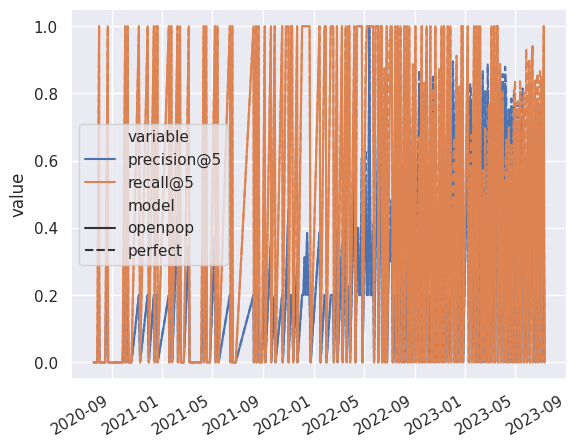

In [31]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [32]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2020-07-19 15:53:31,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2020-07-19 15:53:31,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2020-07-19 15:53:31,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2020-07-28 15:41:46,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
4,2020-08-01 23:57:58,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2023-06-29 21:41:02,0.753398,1.0,0.866158,0.866158,0.466990,1.0,1.0,1.0,0.311327,1.0,1.0,1.0,perfect
359,2023-07-02 20:32:21,0.727273,1.0,0.850649,0.850649,0.463636,1.0,1.0,1.0,0.309091,1.0,1.0,1.0,perfect
360,2023-07-03 16:57:38,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,perfect
361,2023-07-08 23:38:22,0.466667,1.0,1.000000,1.000000,0.233333,1.0,1.0,1.0,0.155556,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

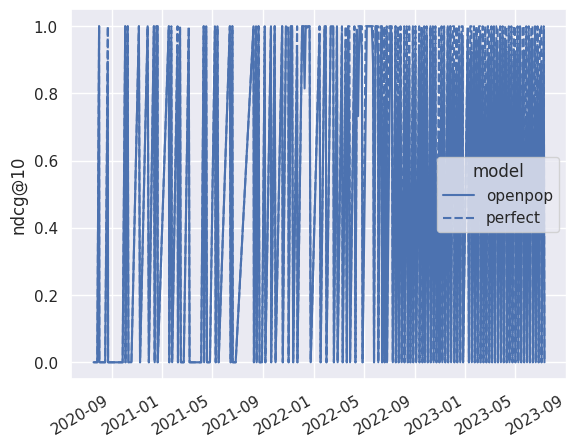

In [33]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [34]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.000000,1.000000,0.066667,1.0,1.0,1.0
4,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
9,0.809231,1.0,0.643881,0.643881,0.695385,1.0,0.891913,0.891913,0.556923,1.0,1.0,1.0


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,0.181468,0.374656,0.351991,0.351991,0.109159,0.374656,0.371459,0.371459,0.075482,0.374656,0.374656,0.374656
std,0.280626,0.484702,0.460819,0.460819,0.187170,0.484702,0.480907,0.480907,0.134252,0.484702,0.484702,0.484702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.290472,1.000000,1.000000,1.000000,0.145236,1.000000,1.000000,1.000000,0.096824,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.845652,1.000000,1.000000,1.000000,0.696014,1.000000,1.000000,1.000000


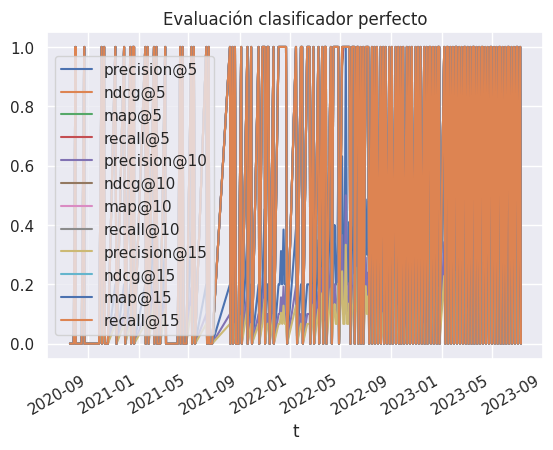

In [35]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [36]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 363 folds
From 2020-07-18 16:12:04 to 2023-07-17 17:57:23


,train,test,open,test users,test vpv,test vpp
count,363.000000,363.000000,363.000000,363.000000,136.000000,136.000000
mean,40222.223140,174.906336,1.595041,76.214876,0.549332,128.731095
std,32472.909542,456.975829,3.018118,232.409747,0.338422,291.176011
min,251.000000,0.000000,0.000000,0.000000,0.094762,0.600000
25%,12839.500000,0.000000,0.000000,0.000000,0.232187,8.321429
50%,36478.000000,0.000000,0.000000,0.000000,0.481969,23.353846
75%,59120.500000,97.000000,2.000000,41.500000,1.000000,57.250000
max,111158.000000,3616.000000,15.000000,2075.000000,1.000000,2075.000000


In [37]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2020-07-21,251,0,0,0,NaN,NaN,NaT,NaT
1,2020-07-24,251,0,0,0,NaN,NaN,NaT,NaT
2,2020-07-27,251,0,0,0,NaN,NaN,NaT,NaT
3,2020-07-30,282,0,0,0,NaN,NaN,NaT,NaT
4,2020-08-02,355,34,1,34,1.000000,34.000000,2020-08-02 00:23:52,2020-08-02 15:59:33
...,...,...,...,...,...,...,...,...,...
358,2023-06-30,110306,505,7,109,0.215842,15.571429,2023-06-30 00:05:24,2023-07-03 16:57:38
359,2023-07-03,110760,51,7,11,0.215686,1.571429,2023-07-03 03:05:20,2023-07-03 16:57:38
360,2023-07-06,110811,0,0,0,NaN,NaN,NaT,NaT
361,2023-07-09,111074,84,3,36,0.428571,12.000000,2023-07-09 03:28:18,2023-07-10 16:33:50


In [38]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 16 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window


In [39]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 16 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window


            train  test  i
t                         
2020-07-21    251     0  0
2020-07-24    251     0  1
2020-07-27    251     0  2
2020-07-30    282     0  3
2020-08-02    355    34  4
2020-08-05    389     0  5
2020-08-08    389     0  6
2020-08-11    389     0  7
2020-08-14    389     0  8
2020-08-17    426     0  9


Cannot show ipywidgets in text

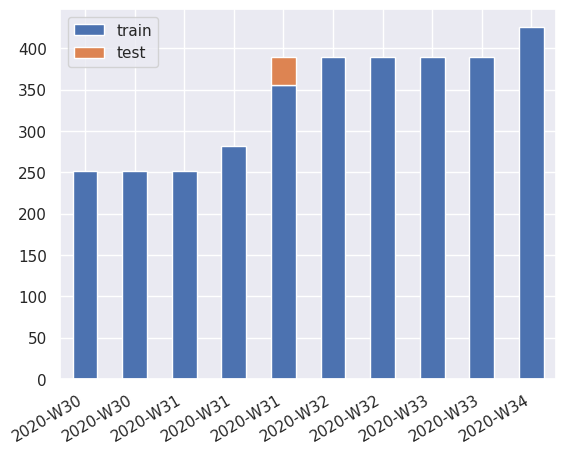

In [40]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

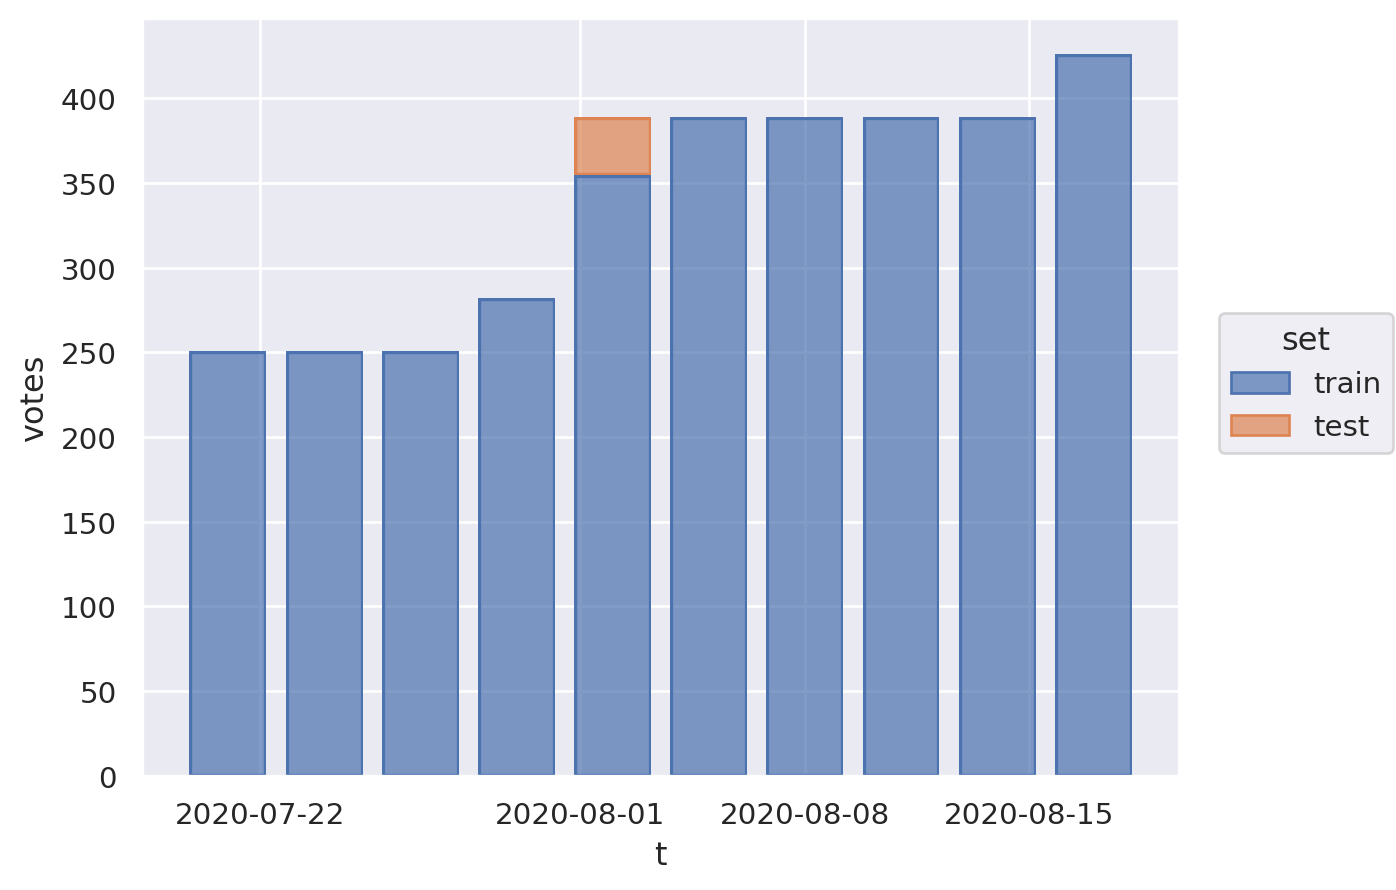

In [41]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())